In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import imageio
import itertools
import shutil
import os
import random
from glob import glob
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Input, Activation, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D, Concatenate
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.optimizers import SGD, Adam
from keras import backend as K 
from keras.utils import plot_model
from keras import layers as KL
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input

%matplotlib inline

Using TensorFlow backend.


In [2]:
class Data_Processing():
    @staticmethod
    def make_working_directories(wd,tr,val,dir1,dir2):
        '''Makes working directory and training & validation directories within working directories.
        After that makes folder with 0 and 1 classification within training and validation directories.
        arguments:- 1. working_directory_name, 2. trainig_directory_name, 3. validation_directory_name,
        4. directory_name_with_class_1, 5. directory_name_with_class_0'''
        # Because I'm sampling a subset of images, I will make separate directory
        # for the sampled images and not mix with the original ones.
        working_dir = wd

        if os.path.exists(working_dir) and os.path.isdir(working_dir):
            shutil.rmtree(working_dir)

        os.mkdir(working_dir)
        # Now make train_dir and validation_dir within working_dir
        train_dir = os.path.join(working_dir, tr)
        validation_dir = os.path.join(working_dir, val)
        os.mkdir(train_dir)
        os.mkdir(validation_dir)

        # now make normal and cancer subfolders inside train directory
        cancer = os.path.join(train_dir, dir1)
        normal = os.path.join(train_dir, dir2)
        os.mkdir(cancer)
        os.mkdir(normal)

        # now make normal and cancer subfolders inside validation directory
        cancer = os.path.join(validation_dir, dir1)
        normal = os.path.join(validation_dir, dir2)
        os.mkdir(cancer)
        os.mkdir(normal)
        print("Finished making directories!")
        return
    
    def print_images(tdd, df,column,n_images):
        '''Prints sample images.'''
        unique_categories = (df.groupby([column])[column].unique()).index
        fig, ax = plt.subplots(nrows=len(unique_categories), ncols=n_images,
                          figsize=(5*n_images, 5*len(unique_categories)))
    
        for i, category in enumerate(unique_categories):
            im = df[df[column]==category].sample(n_images) # n_images is also the sample size
            for j in range(0,n_images):
                file = tdd + im.iloc[j]['id'] + '.tif'
                img = cv2.imread(file)
                ax[i,j].imshow(img, resample=True, cmap='gray')
                color = ['red' if df.iloc[i].label == 1 else 'green'][0]
                ax[i,j].set_title(category, fontsize=36, color=color)
        plt.tight_layout()
        plt.show()
        return
    
    def sampling(df, sample_size):
        '''Takes a subset of images from unbalanced dataset to make balanced
        dataset to work with.'''
        df0 = df[df['label'] == 0].sample(sample_size, random_state=42)
        df1 = df[df['label'] == 1].sample(sample_size, random_state=42)
        
        # now concatenate the dataframes
        df_train = pd.concat([df0, df1], axis=0).reset_index(drop=True)

        # shuffle
        df_train = shuffle(df_train)
        
        return df_train
    
    def split_data(df_train):
        '''Splits data into training and validation sets.'''
        df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42,
                                     stratify=df_train['label'])
        
        # If I don't set the id below as index of the df, it will give error while attaching
        # .tif to the image name
        df.set_index('id', inplace=True)
        
        train_list = list(df_train['id'])
        valid_list = list(df_valid['id'])
        
        return df_train, df_valid, train_list, valid_list
    
    def copy_data(lst, source_directory,target_directory):
        '''Copies data and puts them into respective directories inside working directory.'''
        for image in lst:
            file_name = image + '.tif'
            target = df.loc[image, 'label']
            if target == 0:
                label = 'normal'
            elif target == 1:
                label = 'cancer'
            
            image_source = os.path.join(source_directory, file_name)
            image_destination = os.path.join(target_directory, label, file_name)
            
            # copy the image from source folder to the destination folder
            shutil.copyfile(image_source, image_destination)
            
        print("Finished copying data in ", target_directory, " !")
            
        return

In [3]:
# Check files in the directory
print('Files in the directory ====>', os.listdir('../data'))

# check number of files
print('Number of files in training dataset ====>', len(os.listdir('../data/train')))
print('Number of files in test dataset ====>', len(os.listdir('../data/test')))

Files in the directory ====> ['train_labels.csv', '.DS_Store', 'test', 'train', 'sample_submission.csv']
Number of files in training dataset ====> 220026
Number of files in test dataset ====> 57459


In [4]:
TRAIN_DATA_DIRECTORY = '../data/train/'
TRAIN_LABEL = '../data/train_labels.csv'
TEST_DATA_DIRECTORY = '../data/test/'

# read the image labels 
df = pd.read_csv(TRAIN_LABEL)
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
df.shape

(220025, 2)

In [6]:
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
# Counting 0s and 1s
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

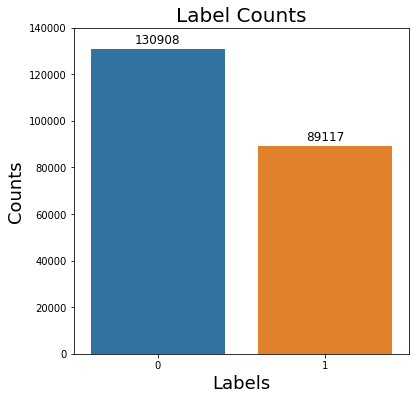

In [8]:
fig = plt.figure(figsize=(6,6))
ax = sns.countplot(df.label).set_title('Label Counts', fontsize=20)
plt.annotate(df.label.value_counts()[0], xy=(0, df.label.value_counts()[0]+1000),
            va = 'bottom', ha = 'center', fontsize=12)
plt.annotate(df.label.value_counts()[1], xy=(1, df.label.value_counts()[1]+1000),
            va = 'bottom', ha = 'center', fontsize=12)

plt.ylim(0,140000)
plt.xlabel("Labels", fontsize=18)
plt.ylabel("Counts", fontsize=18)

plt.show()

In [9]:
cancer_absent = df.label.value_counts()[0]/(df.label.value_counts()[0] + df.label.value_counts()[1])*100
cancer_present = df.label.value_counts()[1]/(df.label.value_counts()[0] + df.label.value_counts()[1])*100

print("Normal =", "%.2f" % cancer_absent,"%")
print("Cancer =", "%.2f" % cancer_present, "%")

Normal = 59.50 %
Cancer = 40.50 %


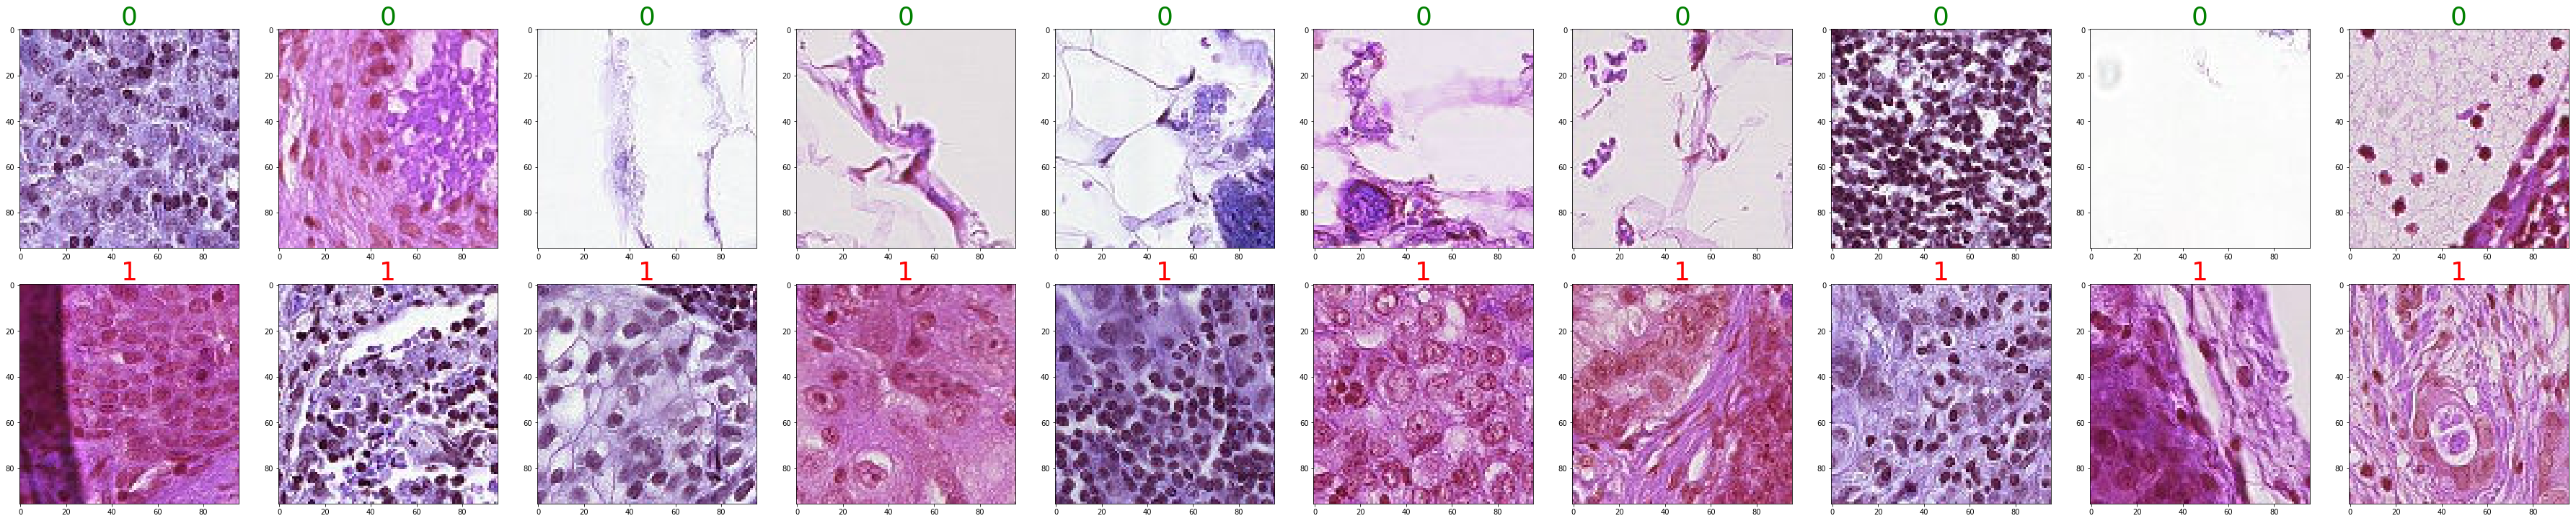

In [10]:
Data_Processing.print_images(TRAIN_DATA_DIRECTORY,df,'label',10)

In [11]:
# taking a subset of 10,000 images with labels 1 and 0 each to make balanced dataset
SAMPLE_SIZE = 20000
df_normal = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state = 42)
df_cancer = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state = 42)

# now let's concatenate the two dataframes
df_sampled = pd.concat([df_normal, df_cancer], axis=0).reset_index(drop=True)

#let's shuffle the dataframe
df_sampled = shuffle(df_sampled)

df_sampled.head()

,id,label
2467,402ca4eccdf378e8f5233873bbc08b38ea8993f2,0
28985,710e80026b86a6ab187b33e415ead47f26faedda,1
19306,2b2388ceb0e433831a454265a0a980293532ecae,0
35200,bc76c7d156128e6c724139a938e2b6ae7fb18ee9,1
3961,c1e1ddd35d445c842c34f6c47122d64778dfddf7,0


In [12]:
df_sampled['label'].value_counts()

1    20000
0    20000
Name: label, dtype: int64

## Splitting the images into train and validation sets
#### Making working directories

In [13]:
Data_Processing.make_working_directories('working_dir', 'train_dir', 'validation_dir', 'cancer', 'normal')

os.listdir()

Finished making directories!


['11-08-2019_Cancer_Detection-Part-1.ipynb',
 'working_dir',
 '11-08-2019_Cancer_Detection-Part-2.ipynb',
 '.ipynb_checkpoints']

In [14]:
print('Files in the working directory ====>', os.listdir('./working_dir'))
print('Files in the working/train directory ====>', os.listdir('./working_dir/train_dir'))
print('Files in the working/validation directory ====>', os.listdir('./working_dir/validation_dir'))

Files in the working directory ====> ['train_dir', 'validation_dir']
Files in the working/train directory ====> ['cancer', 'normal']
Files in the working/validation directory ====> ['cancer', 'normal']


#### Now split the train and validation sets and put them into their respective folders

The `stratify` parameter makes a split so that the porportion of values in the sample produced will be the same as the proportion of values provided to parameter `stratify`.
For example, if variable `y` is binary categorical variable with values `0` and `1` and there are 25% of zeros adn 75% of ones, `stratify=y` will make sure that your random split has 25% of `0`'s and 75% of `1`'s.

In [15]:
df_train, df_valid, train_list, valid_list = Data_Processing.split_data(df_sampled)

print('df_train shape', df_train.shape)
print('df_validation_shape', df_valid.shape)

df_train shape (32000, 2)
df_validation_shape (8000, 2)


In [16]:
Data_Processing.copy_data(train_list,TRAIN_DATA_DIRECTORY,'./working_dir/train_dir')
Data_Processing.copy_data(valid_list,TRAIN_DATA_DIRECTORY,'./working_dir/validation_dir')

Finished copying data in  ./working_dir/train_dir  !
Finished copying data in  ./working_dir/validation_dir  !


In [17]:
print('Number of files in working_dir/train_dir/cancer ====>', \
      len(os.listdir('working_dir/train_dir/cancer')))
print('Number of files in working_dir/train_dir/normal ====>', \
      len(os.listdir('working_dir/train_dir/normal')))
print('Number of files in working_dir/validation_dir/cancer ====>', \
      len(os.listdir('working_dir/validation_dir/cancer')))
print('Number of files in working_dir/validation_dir/normal ====>', \
      len(os.listdir('working_dir/validation_dir/normal')))

Number of files in working_dir/train_dir/cancer ====> 16000
Number of files in working_dir/train_dir/normal ====> 16000
Number of files in working_dir/validation_dir/cancer ====> 4000
Number of files in working_dir/validation_dir/normal ====> 4000


In [19]:
# put the df_sampled to csv file to read later
df_sampled.to_csv('df_sampled.csv', index=False)